In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
#!pip install iterative-stratification
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
import lightgbm as lgb
import catboost as ctb
from catboost import *
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [6]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [7]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [8]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [9]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [10]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = "cover"
print(target)

display(train[target].head(3))

cover


0    0.050
1    0.725
2    0.025
Name: cover, dtype: float64

In [11]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [12]:
len(features), len(knn_features)

(2259, 512)

In [13]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [14]:
len(features), len(knn_features)

(309, 62)

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-15-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-15-b25a66a67f2a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/62 [00:02<02:13,  2.19s/it]<ipython-input-15-b25a66a67f2a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,EVI,AVI,H,mCRIG,Chlgreen,Fe3,NBR2,MAX_CI,GVMI,NDVI,...,Red,TSAVI,NormG,IF,sunAzimuth,TIRS1,Green,TIRS2,CTVI,CI
0,0.076538,-15.589754,1.536542,-0.082768,5.441301,0.502376,0.369581,0.004414,0.938259,-0.464321,...,12.291277,-0.716042,0.593065,2.214614,147.348267,8.243456,24.466267,8.218559,0.410823,-2.621574
1,-0.243384,38.705406,1.410671,-0.049793,1.035625,0.699943,0.724646,-0.048293,0.970958,0.159502,...,50.989620,0.072192,0.375158,12.037422,95.422757,8.649507,72.848259,8.658948,0.568762,-0.506367
2,0.101124,-21.318088,1.532755,-0.072468,4.433729,0.532909,0.697570,4.169011,0.966689,-0.405253,...,18.480610,-0.638658,0.568682,2.973305,151.061766,8.279950,34.678707,8.255633,0.441918,-1.764840
3,0.103533,-17.434855,1.495565,-0.102928,2.197610,0.720089,0.722703,1.480026,0.971023,-0.177638,...,33.735753,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499
4,0.036670,-10.890392,1.554811,-0.070236,6.795114,0.326259,0.710619,-0.002413,0.975787,-0.378296,...,9.919600,-0.601136,0.678692,2.475886,153.361999,8.385872,30.404083,8.375682,-0.089450,-4.863440
5,0.103533,-17.434855,1.495565,-0.102928,2.197610,0.720089,0.722703,-0.065459,0.971023,-0.177638,...,33.735753,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499
6,0.077201,-17.212898,1.540411,-0.084250,4.713927,0.496713,0.709369,-0.049355,0.967538,-0.401461,...,15.022129,-0.633086,0.585189,2.527918,151.061766,8.251698,30.243046,8.259885,0.404647,-2.339526
7,0.079488,-28.176980,1.554245,-0.025008,10.618635,0.348759,0.634860,-0.300877,0.938661,-0.574771,...,19.299984,-0.867709,0.693033,4.602264,128.531133,8.843853,55.338951,7.987241,0.130981,-2.904045
8,0.067698,-19.278593,1.551772,-0.080573,4.803614,0.458650,0.620597,0.143764,0.947639,-0.375620,...,17.650833,-0.599333,0.599942,2.714684,126.264466,9.141504,38.484325,9.141788,0.358983,-2.557023
9,0.061686,-13.479237,1.540390,-0.081238,5.361523,0.443215,0.683367,-0.014208,0.958180,-0.407637,...,11.636496,-0.640413,0.613599,2.443077,153.816328,8.520046,26.254721,8.492517,0.337943,-2.997296


,EVI,AVI,H,mCRIG,Chlgreen,Fe3,NBR2,MAX_CI,GVMI,NDVI,...,Red,TSAVI,NormG,IF,sunAzimuth,TIRS1,Green,TIRS2,CTVI,CI
0,0.103533,-17.434855,1.495565,-0.102928,2.197610,0.720089,0.722703,-0.010624,0.971023,-0.177638,...,33.735753,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499
1,0.050914,-13.141754,1.544322,-0.097787,4.045716,0.438826,0.625434,-0.031198,0.950813,-0.271374,...,15.177749,-0.463083,0.592326,3.004079,128.573050,8.792016,35.449848,8.814009,0.324673,-2.681994
2,0.091191,-15.260981,1.497484,-0.108825,1.945585,0.722763,0.707265,0.036575,0.970344,-0.144751,...,33.772681,-0.303412,0.441041,3.320265,127.929376,8.868892,46.699800,8.837255,0.581877,-0.717734
3,0.052273,-14.263588,1.552029,-0.069664,6.891628,0.393594,0.787176,4.349364,0.975033,-0.461280,...,11.296329,-0.711587,0.649900,2.313358,138.032189,8.604989,28.700424,8.568386,0.254681,-3.886865
4,0.167693,-36.870170,1.529995,-0.035106,7.386919,0.573220,0.665161,0.069147,0.960639,-0.617907,...,24.134905,-0.928132,0.585277,3.437880,154.492638,8.590875,42.104111,7.937538,0.478249,-1.355335
5,0.086634,-15.247592,1.503037,-0.107664,2.213430,0.706031,0.708617,-0.062754,0.970612,-0.170528,...,32.193857,-0.337300,0.452128,3.231371,127.929376,8.869017,45.417629,8.838213,0.570722,-0.798512
6,0.054797,-13.700280,1.547764,-0.085535,5.185413,0.427119,0.560829,0.030087,0.963987,-0.377875,...,12.489099,-0.601392,0.617296,2.437501,153.816328,8.520046,29.240328,8.549272,0.313967,-3.207379
7,0.067871,-19.287441,1.550916,-0.050608,7.459252,0.392799,0.614958,0.165662,0.935326,-0.491092,...,14.640511,-0.752735,0.654939,3.002557,132.150790,9.294236,37.272316,8.479495,0.253065,-3.089695
8,0.061939,-13.437099,1.538688,-0.082478,4.872731,0.443940,0.812505,0.211715,0.976178,-0.367729,...,12.494470,-0.588053,0.606368,2.655085,153.816328,8.452959,28.144505,8.483115,0.338970,-2.766143
9,0.103533,-17.434855,1.495565,-0.102928,2.197610,0.720089,0.722703,-0.316521,0.971023,-0.177638,...,33.735753,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499


## Model

In [16]:
class CFG:
  ver=74
  model="catboost"
  n_folds=15
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  seed=42
  boosting_type="gbdt"

In [17]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [18]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [19]:
#features = list(features)
features.remove('id')
#features.remove('area')
features.remove("year")
#features.remove("month")
#features.append("mesh20")
#features.remove("PRODUCT_ID")

In [29]:
params = {
        "loss_function":"RMSE",
        "n_estimators":6000,
        "random_seed":2022,
        "learning_rate":0.05
  }

In [31]:
def get_pred(df, test, params):
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))
  params["n_estimators"] = 6000

  categorical_features = ["month","Landsat_num"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target].values
      valid_labels = valid_folds[target].values

      #clf = model
      params["n_estimators"] += 250
      clf = ctb.CatBoostRegressor(**params,
                                    #task_type='GPU'
                                    )
      clf.fit(train_X, train_labels,
                eval_set=[(train_X,train_labels),(valid_X, valid_labels)],
                verbose = 200,
                early_stopping_rounds = 50,
                #cat_features=categorical_features,
                use_best_model=True
            )
      
      valid_folds[f"pred"] = clf.predict(valid_X)
      test_preds[:, fold] = clf.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      #f_importance = np.array(clf.feature_importances_)
      #temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      #df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds["pred"])

  #df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  #df_importance = df_importance.sort_values('importance', ascending=False)
  #display(df_importance.head(35))
  #fig = plt.figure(figsize=(16, 32), tight_layout=True)
  #sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  #plt.title("LightGBM feature importances")
  get_score(oof_df[target], oof_df[f"pred"])
  return oof_df,  test_preds

In [32]:
train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)
train = get_fold(train)
oof_preds = []
preds = np.zeros((len(test), 4))
seeds = [42, 18, 0, 2023]
for i in range(4):
  print("#"*15,f" SEED : {CFG.seed} ","#"*15)
  params["random_seed"] = seeds[i]
  oof_df, test_pred = get_pred(train, test, params)
  pred = np.mean(test_pred, axis=1)
  preds[:, i] = pred
  oof_preds.append(oof_df["pred"].values)
  print()

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3105265	test: 0.3105265	test1: 0.3147512	best: 0.3147512 (0)	total: 166ms	remaining: 17m 20s
200:	learn: 0.1182712	test: 0.1182712	test1: 0.1731761	best: 0.1731761 (200)	total: 15.9s	remaining: 7m 58s
400:	learn: 0.0852258	test: 0.0852258	test1: 0.1633158	best: 0.1632010 (394)	total: 31.7s	remaining: 7m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1606644263
bestIteration = 532

Shrink model to first 533 iterations.
RMSE 0.16066442677960102
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3141783	test: 0.3141783	test1: 0.3577012	best: 0.3577012 (0)	total: 94.7ms	remaining: 10m 15s
200:	learn: 0.1167778	test: 0.1167778	test1: 0.0886653	best: 0.0886653 (200)	total: 16.7s	remaining: 8m 44s
400:	learn: 0.0884319	test: 0.0884319	test1: 0.0815287	best: 0.0815147 (392)	total: 34.2s	remaining: 8m 40s
600:	learn: 0.0732774	test: 0.0732774	test1: 0.0797318	best: 0.0797318 (600)	total: 51.8s	remaining: 8m 28s
800:	learn: 0.0631753	test: 0.0631753	test1: 0.0791736	best: 0.0791736 (800)	total: 1m 7s	remaining: 8m 3s
1000:	learn: 0.0556538	test: 0.0556538	test1: 0.0786206	best: 0.0786206 (1000)	total: 1m 24s	remaining: 7m 46s
1200:	learn: 0.0495883	test: 0.0495883	test1: 0.0782132	best: 0.0781858 (1195)	total: 1m 41s	remaining: 7m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07804651201
bestIteration = 1268

Shrink model to first 1269 iterations.
RMSE 0.07804651251427458
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 20

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3200445	test: 0.3200445	test1: 0.3011409	best: 0.3011409 (0)	total: 100ms	remaining: 11m 18s
200:	learn: 0.1064488	test: 0.1064488	test1: 0.1457495	best: 0.1457066 (196)	total: 16.7s	remaining: 9m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1442970312
bestIteration = 349

Shrink model to first 350 iterations.
RMSE 0.14429703134757507
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3081189	test: 0.3081189	test1: 0.2376264	best: 0.2376264 (0)	total: 98.9ms	remaining: 11m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1327407976
bestIteration = 139

Shrink model to first 140 iterations.
RMSE 0.13274079798078198
===============  FOLD : 4  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2960023	test: 0.2960023	test1: 0.1909943	best: 0.1909943 (0)	total: 161ms	remaining: 19m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1057281237
bestIteration = 58

Shrink model to first 59 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.10572812555946341
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2794544	test: 0.2794544	test1: 0.1657888	best: 0.1657888 (0)	total: 397ms	remaining: 49m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06047908374
bestIteration = 77

Shrink model to first 78 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.060479084836193533
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2628118	test: 0.2628118	test1: 0.1992722	best: 0.1992722 (0)	total: 142ms	remaining: 18m 16s
200:	learn: 0.0921875	test: 0.0921875	test1: 0.1793235	best: 0.1793177 (199)	total: 19.3s	remaining: 12m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1759464364
bestIteration = 324

Shrink model to first 325 iterations.
RMSE 0.17594643957214007
===============  FOLD : 7  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2585183	test: 0.2585183	test1: 0.1329667	best: 0.1329667 (0)	total: 111ms	remaining: 14m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05896599533
bestIteration = 89

Shrink model to first 90 iterations.
RMSE 0.058965995637466934
===============  FOLD : 8  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2471477	test: 0.2471477	test1: 0.1221940	best: 0.1221940 (0)	total: 108ms	remaining: 14m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1019294526
bestIteration = 10

Shrink model to first 11 iterations.
RMSE 0.1019294532037843
===============  FOLD : 9  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2321412	test: 0.2321412	test1: 0.1216638	best: 0.1216638 (0)	total: 106ms	remaining: 15m 4s
200:	learn: 0.0904117	test: 0.0904117	test1: 0.0680921	best: 0.0680921 (200)	total: 21.8s	remaining: 14m 58s
400:	learn: 0.0744656	test: 0.0744656	test1: 0.0601395	best: 0.0601395 (400)	total: 40.2s	remaining: 13m 32s
600:	learn: 0.0651481	test: 0.0651481	test1: 0.0551069	best: 0.0551057 (599)	total: 58.2s	remaining: 12m 45s
800:	learn: 0.0585136	test: 0.0585136	test1: 0.0510601	best: 0.0510601 (800)	total: 1m 17s	remaining: 12m 24s
1000:	learn: 0.0528451	test: 0.0528451	test1: 0.0473588	best: 0.0473559 (999)	total: 1m 36s	remaining: 12m
1200:	learn: 0.0486367	test: 0.0486367	test1: 0.0452663	best: 0.0452624 (1199)	total: 1m 54s	remaining: 11m 34s
1400:	learn: 0.0448125	test: 0.0448125	test1: 0.0436670	best: 0.0436670 (1400)	total: 2m 12s	remaining: 11m 11s
1600:	learn: 0.0417029	test: 0.0417029	test1

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.03381974064014548
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2290242	test: 0.2290242	test1: 0.2830293	best: 0.2830293 (0)	total: 110ms	remaining: 16m 1s
200:	learn: 0.0887755	test: 0.0887755	test1: 0.2482676	best: 0.2482410 (199)	total: 18.3s	remaining: 12m 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.242238955
bestIteration = 324

Shrink model to first 325 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.24223895536819703
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2355538	test: 0.2355538	test1: 0.2452259	best: 0.2452259 (0)	total: 128ms	remaining: 19m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2224839938
bestIteration = 40

Shrink model to first 41 iterations.
RMSE 0.22248399406040018
===============  FOLD : 12  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2349195	test: 0.2349195	test1: 0.3201005	best: 0.3201005 (0)	total: 116ms	remaining: 17m 53s
200:	learn: 0.1060863	test: 0.1060863	test1: 0.2678322	best: 0.2678322 (200)	total: 21s	remaining: 15m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2668473745
bestIteration = 251

Shrink model to first 252 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2668473746261048
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2491386	test: 0.2491386	test1: 0.3420625	best: 0.3420625 (0)	total: 212ms	remaining: 33m 35s
200:	learn: 0.1231329	test: 0.1231329	test1: 0.1868121	best: 0.1868121 (200)	total: 20.1s	remaining: 15m 27s
400:	learn: 0.1027006	test: 0.1027006	test1: 0.1590105	best: 0.1590093 (399)	total: 38.8s	remaining: 14m 41s
600:	learn: 0.0903864	test: 0.0903864	test1: 0.1449801	best: 0.1449801 (600)	total: 59.8s	remaining: 14m 45s
800:	learn: 0.0814622	test: 0.0814622	test1: 0.1364639	best: 0.1364639 (800)	total: 1m 18s	remaining: 14m 14s
1000:	learn: 0.0744836	test: 0.0744836	test1: 0.1313253	best: 0.1313217 (999)	total: 1m 37s	remaining: 13m 46s
1200:	learn: 0.0688143	test: 0.0688143	test1: 0.1277250	best: 0.1277250 (1200)	total: 1m 58s	remaining: 13m 37s
1400:	learn: 0.0638843	test: 0.0638843	test1: 0.1255992	best: 0.1255992 (1400)	to

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1180312484397261
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2562354	test: 0.2562354	test1: 0.3381726	best: 0.3381726 (0)	total: 119ms	remaining: 19m 21s
200:	learn: 0.1282675	test: 0.1282675	test1: 0.1951532	best: 0.1951532 (200)	total: 19.2s	remaining: 15m 13s
400:	learn: 0.1076989	test: 0.1076989	test1: 0.1695704	best: 0.1695704 (400)	total: 39.8s	remaining: 15m 28s
600:	learn: 0.0947798	test: 0.0947798	test1: 0.1556177	best: 0.1556177 (600)	total: 59.2s	remaining: 15m 1s
800:	learn: 0.0860025	test: 0.0860025	test1: 0.1483219	best: 0.1483219 (800)	total: 1m 18s	remaining: 14m 33s
1000:	learn: 0.0791231	test: 0.0791231	test1: 0.1422980	best: 0.1422980 (1000)	total: 1m 39s	remaining: 14m 26s
1200:	learn: 0.0734816	test: 0.0734816	test1: 0.1376304	best: 0.1376304 (1200)	total: 1m 58s	remaining: 14m
1400:	learn: 0.0687484	test: 0.0687484	test1: 0.1342811	best: 0.1342157 (1382)	total: 

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12202018615375032
RMSE 0.1505314277035162

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3107887	test: 0.3107887	test1: 0.3158008	best: 0.3158008 (0)	total: 109ms	remaining: 11m 22s
200:	learn: 0.1196131	test: 0.1196131	test1: 0.1701499	best: 0.1701499 (200)	total: 16.2s	remaining: 8m 8s
400:	learn: 0.0848545	test: 0.0848545	test1: 0.1605876	best: 0.1604456 (398)	total: 32.3s	remaining: 7m 50s
600:	learn: 0.0672104	test: 0.0672104	test1: 0.1581429	best: 0.1581408 (599)	total: 48.4s	remaining: 7m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1577829823
bestIteration = 637

Shrink model to first 638 iterations.
RMSE 0.15778298272513744
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3143263	test: 0.3143263	test1: 0.3576353	best: 0.3576353 (0)	total: 110ms	remaining: 11m 57s
200:	learn: 0.1166087	test: 0.1166087	test1: 0.0878097	best: 0.0878097 (200)	total: 16.6s	remaining: 8m 40s
400:	learn: 0.0872303	test: 0.0872303	test1: 0.0802172	best: 0.0802172 (400)	total: 33.1s	remaining: 8m 24s
600:	learn: 0.0723977	test: 0.0723977	test1: 0.0782131	best: 0.0782083 (598)	total: 49.5s	remaining: 8m 5s
800:	learn: 0.0624158	test: 0.0624158	test1: 0.0772588	best: 0.0772305 (798)	total: 1m 6s	remaining: 7m 52s
1000:	learn: 0.0547518	test: 0.0547518	test1: 0.0767583	best: 0.0767509 (993)	total: 1m 25s	remaining: 7m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07654262186
bestIteration = 1127

Shrink model to first 1128 iterations.
RMSE 0.07654262240373047
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3207133	test: 0.3207133	test1: 0.3038683	best: 0.3038683 (0)	total: 102ms	remaining: 11m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1556350335
bestIteration = 135

Shrink model to first 136 iterations.
RMSE 0.15563503370566928
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3081756	test: 0.3081756	test1: 0.2346476	best: 0.2346476 (0)	total: 105ms	remaining: 12m 11s
200:	learn: 0.1064305	test: 0.1064305	test1: 0.1073772	best: 0.1063737 (187)	total: 17.2s	remaining: 9m 40s
400:	learn: 0.0838919	test: 0.0838919	test1: 0.1013118	best: 0.1008626 (390)	total: 34.1s	remaining: 9m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1008625933
bestIteration = 390

Shrink model to first 391 iterations.
RMSE 0.10086259358849935
===============  FOLD : 4  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2959401	test: 0.2959401	test1: 0.1906847	best: 0.1906847 (0)	total: 199ms	remaining: 24m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09773184989
bestIteration = 104

Shrink model to first 105 iterations.
RMSE 0.09773185177929498
===============  FOLD : 5  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2794766	test: 0.2794766	test1: 0.1650056	best: 0.1650056 (0)	total: 202ms	remaining: 25m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06004211111
bestIteration = 73

Shrink model to first 74 iterations.
RMSE 0.06004211222042052
===============  FOLD : 6  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2629589	test: 0.2629589	test1: 0.1998936	best: 0.1998936 (0)	total: 159ms	remaining: 20m 28s
200:	learn: 0.0920590	test: 0.0920590	test1: 0.1789963	best: 0.1789124 (199)	total: 19.8s	remaining: 12m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1768845306
bestIteration = 302

Shrink model to first 303 iterations.
RMSE 0.17688453385727884
===============  FOLD : 7  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2586011	test: 0.2586011	test1: 0.1339494	best: 0.1339494 (0)	total: 108ms	remaining: 14m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05783614434
bestIteration = 127

Shrink model to first 128 iterations.
RMSE 0.05783614459747178
===============  FOLD : 8  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2473870	test: 0.2473870	test1: 0.1218893	best: 0.1218893 (0)	total: 111ms	remaining: 15m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1010143765
bestIteration = 13

Shrink model to first 14 iterations.
RMSE 0.1010143770815586
===============  FOLD : 9  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2322903	test: 0.2322903	test1: 0.1216394	best: 0.1216394 (0)	total: 167ms	remaining: 23m 36s
200:	learn: 0.0907395	test: 0.0907395	test1: 0.0667779	best: 0.0667779 (200)	total: 20.3s	remaining: 13m 56s
400:	learn: 0.0745983	test: 0.0745983	test1: 0.0595220	best: 0.0595220 (400)	total: 38.3s	remaining: 12m 54s
600:	learn: 0.0652688	test: 0.0652688	test1: 0.0538217	best: 0.0538199 (599)	total: 56.3s	remaining: 12m 19s
800:	learn: 0.0582677	test: 0.0582677	test1: 0.0497022	best: 0.0497022 (800)	total: 1m 16s	remaining: 12m 13s
1000:	learn: 0.0526992	test: 0.0526992	test1: 0.0467449	best: 0.0467449 (1000)	total: 1m 34s	remaining: 11m 47s
1200:	learn: 0.0484071	test: 0.0484071	test1: 0.0444347	best: 0.0444327 (1199)	total: 1m 52s	remaining: 11m 23s
1400:	learn: 0.0447766	test: 0.0447766	test1: 0.0423338	best: 0.0423338 (1400)	total: 2m 12s	remaining: 11m 11s
1600:	learn: 0.0416859	test: 0.0416859

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.03300248933308031
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2292738	test: 0.2292738	test1: 0.2834331	best: 0.2834331 (0)	total: 119ms	remaining: 17m 21s
200:	learn: 0.0896295	test: 0.0896295	test1: 0.2578925	best: 0.2574198 (196)	total: 18.4s	remaining: 13m 3s
400:	learn: 0.0741828	test: 0.0741828	test1: 0.2481720	best: 0.2481720 (400)	total: 36.5s	remaining: 12m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2472908438
bestIteration = 438

Shrink model to first 439 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.24729084421108233
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2356365	test: 0.2356365	test1: 0.2450506	best: 0.2450506 (0)	total: 113ms	remaining: 16m 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2200391089
bestIteration = 39

Shrink model to first 40 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.22003910919825787
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2351233	test: 0.2351233	test1: 0.3194680	best: 0.3194680 (0)	total: 119ms	remaining: 18m 23s
200:	learn: 0.1061781	test: 0.1061781	test1: 0.2690545	best: 0.2690545 (200)	total: 18.9s	remaining: 14m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.268534889
bestIteration = 223

Shrink model to first 224 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2685348891173591
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2492519	test: 0.2492519	test1: 0.3420682	best: 0.3420682 (0)	total: 197ms	remaining: 31m 13s
200:	learn: 0.1235020	test: 0.1235020	test1: 0.1884681	best: 0.1884681 (200)	total: 19.6s	remaining: 15m 4s
400:	learn: 0.1024257	test: 0.1024257	test1: 0.1602560	best: 0.1602560 (400)	total: 38.4s	remaining: 14m 30s
600:	learn: 0.0896676	test: 0.0896676	test1: 0.1440023	best: 0.1440023 (600)	total: 59.4s	remaining: 14m 40s
800:	learn: 0.0809162	test: 0.0809162	test1: 0.1353503	best: 0.1353503 (800)	total: 1m 18s	remaining: 14m 11s
1000:	learn: 0.0737929	test: 0.0737929	test1: 0.1300253	best: 0.1300250 (998)	total: 1m 37s	remaining: 13m 50s
1200:	learn: 0.0682078	test: 0.0682078	test1: 0.1271413	best: 0.1271413 (1200)	total: 1m 58s	remaining: 13m 37s
1400:	learn: 0.0632963	test: 0.0632963	test1: 0.1246402	best: 0.1246402 (1400)	tot

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11684941119906092
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2562759	test: 0.2562759	test1: 0.3382931	best: 0.3382931 (0)	total: 116ms	remaining: 18m 51s
200:	learn: 0.1278651	test: 0.1278651	test1: 0.1932782	best: 0.1932782 (200)	total: 19.3s	remaining: 15m 16s
400:	learn: 0.1074292	test: 0.1074292	test1: 0.1687531	best: 0.1687531 (400)	total: 39.6s	remaining: 15m 22s
600:	learn: 0.0946783	test: 0.0946783	test1: 0.1542749	best: 0.1542749 (600)	total: 59.2s	remaining: 15m 1s
800:	learn: 0.0855791	test: 0.0855791	test1: 0.1447526	best: 0.1447526 (800)	total: 1m 18s	remaining: 14m 33s
1000:	learn: 0.0784245	test: 0.0784245	test1: 0.1383694	best: 0.1383529 (998)	total: 1m 39s	remaining: 14m 27s
1200:	learn: 0.0728574	test: 0.0728574	test1: 0.1345554	best: 0.1345554 (1200)	total: 1m 58s	remaining: 14m 1s
1400:	learn: 0.0681381	test: 0.0681381	test1: 0.1308684	best: 0.1308684 (1400)	tota

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1197377743401427
RMSE 0.1492983588320113

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3105918	test: 0.3105918	test1: 0.3141853	best: 0.3141853 (0)	total: 185ms	remaining: 19m 17s
200:	learn: 0.1183231	test: 0.1183231	test1: 0.1697171	best: 0.1697171 (200)	total: 19.3s	remaining: 9m 40s
400:	learn: 0.0849874	test: 0.0849874	test1: 0.1601581	best: 0.1601581 (400)	total: 35.4s	remaining: 8m 36s
600:	learn: 0.0676761	test: 0.0676761	test1: 0.1569448	best: 0.1569197 (598)	total: 51.5s	remaining: 8m 4s
800:	learn: 0.0564663	test: 0.0564663	test1: 0.1555205	best: 0.1555205 (800)	total: 1m 7s	remaining: 7m 40s
1000:	learn: 0.0488868	test: 0.0488868	test1: 0.1549351	best: 0.1549138 (995)	total: 1m 23s	remaining: 7m 19s
1200:	learn: 0.0439795	test: 0.0439795	test1: 0.1542697	best: 0.1542317 (1198)	total: 1m 41s	remaining: 7m 5s
Stopped by overfitting d

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
0:	learn: 0.3143633	test: 0.3143633	test1: 0.3579278	best: 0.3579278 (0)	total: 179ms	remaining: 19m 20s
200:	learn: 0.1167137	test: 0.1167137	test1: 0.0884390	best: 0.0884390 (200)	total: 18.4s	remaining: 9m 35s
400:	learn: 0.0887184	test: 0.0887184	test1: 0.0811869	best: 0.0811869 (400)	total: 34.9s	remaining: 8m 51s
600:	learn: 0.0727759	test: 0.0727759	test1: 0.0793746	best: 0.0793556 (598)	total: 51.4s	remaining: 8m 24s
800:	learn: 0.0630744	test: 0.0630744	test1: 0.0785055	best: 0.0783957 (777)	total: 1m 7s	remaining: 8m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07839570394
bestIteration = 777

Shrink model to first 778 iterations.
RMSE 0.07839570452574321
===============  FOLD : 2  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
0:	learn: 0.3205847	test: 0.3205847	test1: 0.3014563	best: 0.3014563 (0)	total: 124ms	remaining: 13m 53s
200:	learn: 0.1064120	test: 0.1064120	test1: 0.1402947	best: 0.1402136 (172)	total: 18.4s	remaining: 9m 59s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1398389225
bestIteration = 269

Shrink model to first 270 iterations.
RMSE 0.13983892268980738
===============  FOLD : 3  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
0:	learn: 0.3083966	test: 0.3083966	test1: 0.2364008	best: 0.2364008 (0)	total: 102ms	remaining: 11m 56s
200:	learn: 0.1073248	test: 0.1073248	test1: 0.1193293	best: 0.1186559 (192)	total: 18.4s	remaining: 10m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1159273451
bestIteration = 304

Shrink model to first 305 iterations.
RMSE 0.11592734543345098
===============  FOLD : 4  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
0:	learn: 0.2960416	test: 0.2960416	test1: 0.1919286	best: 0.1919286 (0)	total: 190ms	remaining: 22m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1026037814
bestIteration = 138

Shrink model to first 139 iterations.
RMSE 0.10260378332856379
===============  FOLD : 5  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2799273	test: 0.2799273	test1: 0.1657305	best: 0.1657305 (0)	total: 113ms	remaining: 14m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06108609762
bestIteration = 85

Shrink model to first 86 iterations.
RMSE 0.061086098723631826
===============  FOLD : 6  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2629586	test: 0.2629586	test1: 0.1991445	best: 0.1991445 (0)	total: 107ms	remaining: 13m 49s
200:	learn: 0.0919497	test: 0.0919497	test1: 0.1808932	best: 0.1806007 (188)	total: 17.6s	remaining: 11m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.179674493
bestIteration = 289

Shrink model to first 290 iterations.
RMSE 0.1796744962306441
===============  FOLD : 7  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2584373	test: 0.2584373	test1: 0.1338692	best: 0.1338692 (0)	total: 116ms	remaining: 15m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05907851382
bestIteration = 117

Shrink model to first 118 iterations.
RMSE 0.05907851408236475
===============  FOLD : 8  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2473321	test: 0.2473321	test1: 0.1223851	best: 0.1223851 (0)	total: 119ms	remaining: 16m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.09767273562
bestIteration = 17

Shrink model to first 18 iterations.
RMSE 0.0976727361695878
===============  FOLD : 9  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2321326	test: 0.2321326	test1: 0.1216107	best: 0.1216107 (0)	total: 211ms	remaining: 29m 56s
200:	learn: 0.0908280	test: 0.0908280	test1: 0.0678185	best: 0.0678185 (200)	total: 19.8s	remaining: 13m 38s
400:	learn: 0.0751474	test: 0.0751474	test1: 0.0605266	best: 0.0605226 (391)	total: 37.8s	remaining: 12m 43s
600:	learn: 0.0653259	test: 0.0653259	test1: 0.0555753	best: 0.0555753 (600)	total: 55.9s	remaining: 12m 15s
800:	learn: 0.0584107	test: 0.0584107	test1: 0.0506341	best: 0.0506341 (800)	total: 1m 16s	remaining: 12m 11s
1000:	learn: 0.0535036	test: 0.0535036	test1: 0.0480074	best: 0.0479950 (999)	total: 1m 34s	remaining: 11m 44s
1200:	learn: 0.0490665	test: 0.0490665	test1: 0.0456831	best: 0.0456831 (1200)	total: 1m 52s	remaining: 11m 21s
1400:	learn: 0.0453452	test: 0.0453452	test1: 0.0440795	best: 0.0440744 (1394)	total: 2m 12s	remaining: 11m 10s
1600:	learn: 0.0421362	test: 0.0421362	

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.034237618273961004
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2291097	test: 0.2291097	test1: 0.2835618	best: 0.2835618 (0)	total: 113ms	remaining: 16m 28s
200:	learn: 0.0897514	test: 0.0897514	test1: 0.2534338	best: 0.2534338 (200)	total: 18.3s	remaining: 12m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2447466201
bestIteration = 329

Shrink model to first 330 iterations.
RMSE 0.24474662048647716
===============  FOLD : 11  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2358756	test: 0.2358756	test1: 0.2455683	best: 0.2455683 (0)	total: 117ms	remaining: 17m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2231514379
bestIteration = 40

Shrink model to first 41 iterations.
RMSE 0.2231514381299748
===============  FOLD : 12  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2351578	test: 0.2351578	test1: 0.3203172	best: 0.3203172 (0)	total: 111ms	remaining: 17m 9s
200:	learn: 0.1062628	test: 0.1062628	test1: 0.2660871	best: 0.2657935 (197)	total: 19.4s	remaining: 14m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2644119111
bestIteration = 279

Shrink model to first 280 iterations.


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.26441191121507346
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2493745	test: 0.2493745	test1: 0.3432522	best: 0.3432522 (0)	total: 133ms	remaining: 20m 59s
200:	learn: 0.1239105	test: 0.1239105	test1: 0.1883458	best: 0.1883458 (200)	total: 21.2s	remaining: 16m 19s
400:	learn: 0.1027457	test: 0.1027457	test1: 0.1585081	best: 0.1585081 (400)	total: 39.9s	remaining: 15m 6s
600:	learn: 0.0902938	test: 0.0902938	test1: 0.1445982	best: 0.1445961 (599)	total: 1m	remaining: 14m 48s
800:	learn: 0.0812769	test: 0.0812769	test1: 0.1359933	best: 0.1359933 (800)	total: 1m 19s	remaining: 14m 26s
1000:	learn: 0.0741051	test: 0.0741051	test1: 0.1304369	best: 0.1304369 (1000)	total: 1m 38s	remaining: 13m 57s
1200:	learn: 0.0683231	test: 0.0683231	test1: 0.1265859	best: 0.1265859 (1200)	total: 1m 59s	remaining: 13m 46s
1400:	learn: 0.0635311	test: 0.0635311	test1: 0.1238629	best: 0.1238581 (1391)	tota

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11809585780169037
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2565710	test: 0.2565710	test1: 0.3389535	best: 0.3389535 (0)	total: 120ms	remaining: 19m 29s
200:	learn: 0.1279600	test: 0.1279600	test1: 0.1933330	best: 0.1933330 (200)	total: 20s	remaining: 15m 51s
400:	learn: 0.1070936	test: 0.1070936	test1: 0.1656894	best: 0.1655594 (397)	total: 40.4s	remaining: 15m 43s
600:	learn: 0.0944146	test: 0.0944146	test1: 0.1514925	best: 0.1514925 (600)	total: 59.4s	remaining: 15m 4s
800:	learn: 0.0851406	test: 0.0851406	test1: 0.1427546	best: 0.1427546 (800)	total: 1m 20s	remaining: 14m 59s
1000:	learn: 0.0782148	test: 0.0782148	test1: 0.1359843	best: 0.1359843 (1000)	total: 1m 39s	remaining: 14m 28s
1200:	learn: 0.0726783	test: 0.0726783	test1: 0.1309780	best: 0.1309722 (1198)	total: 1m 58s	remaining: 14m 2s
1400:	learn: 0.0679751	test: 0.0679751	test1: 0.1271223	best: 0.1271223 (1400)	total

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.10776758922588876
RMSE 0.1481151373973063

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
0:	learn: 0.3105803	test: 0.3105803	test1: 0.3140549	best: 0.3140549 (0)	total: 102ms	remaining: 10m 37s
200:	learn: 0.1178296	test: 0.1178296	test1: 0.1685444	best: 0.1685444 (200)	total: 16.6s	remaining: 8m 19s
400:	learn: 0.0863502	test: 0.0863502	test1: 0.1589673	best: 0.1589673 (400)	total: 34.3s	remaining: 8m 20s
600:	learn: 0.0682522	test: 0.0682522	test1: 0.1561818	best: 0.1561818 (600)	total: 50.4s	remaining: 7m 53s
800:	learn: 0.0569283	test: 0.0569283	test1: 0.1550122	best: 0.1548653 (765)	total: 1m 6s	remaining: 7m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1545562223
bestIteration = 823

Shrink model to first 824 iterations.
RMSE 0.1545562229254944
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3142461	test: 0.3142461	test1: 0.3574856	best: 0.3574856 (0)	total: 98ms	remaining: 10m 36s
200:	learn: 0.1168430	test: 0.1168430	test1: 0.0879557	best: 0.0879557 (200)	total: 18.1s	remaining: 9m 26s
400:	learn: 0.0883907	test: 0.0883907	test1: 0.0821490	best: 0.0821490 (400)	total: 35.2s	remaining: 8m 54s
600:	learn: 0.0729040	test: 0.0729040	test1: 0.0802173	best: 0.0802173 (600)	total: 51.7s	remaining: 8m 27s
800:	learn: 0.0628177	test: 0.0628177	test1: 0.0792120	best: 0.0791228 (776)	total: 1m 8s	remaining: 8m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.07906689861
bestIteration = 840

Shrink model to first 841 iterations.
RMSE 0.07906689912845176
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3203654	test: 0.3203654	test1: 0.3033367	best: 0.3033367 (0)	total: 99.4ms	remaining: 11m 10s
200:	learn: 0.1059062	test: 0.1059062	test1: 0.1482818	best: 0.1481731 (199)	total: 16.9s	remaining: 9m 11s
400:	learn: 0.0827733	test: 0.0827733	test1: 0.1468906	best: 0.1465527 (367)	total: 33.7s	remaining: 8m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1465527345
bestIteration = 367

Shrink model to first 368 iterations.
RMSE 0.14655273469745822
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.3085721	test: 0.3085721	test1: 0.2372744	best: 0.2372744 (0)	total: 110ms	remaining: 12m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1433147783
bestIteration = 41

Shrink model to first 42 iterations.
RMSE 0.14331477865225967
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


0:	learn: 0.2965990	test: 0.2965990	test1: 0.1974727	best: 0.1974727 (0)	total: 110ms	remaining: 13m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1084337868
bestIteration = 92

Shrink model to first 93 iterations.
RMSE 0.10843378860723912
===============  FOLD : 5  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
0:	learn: 0.2799017	test: 0.2799017	test1: 0.1656772	best: 0.1656772 (0)	total: 112ms	remaining: 14m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06047576195
bestIteration = 73

Shrink model to first 74 iterations.
RMSE 0.06047576307730828
===============  FOLD : 6  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
0:	learn: 0.2630560	test: 0.2630560	test1: 0.1994677	best: 0.1994677 (0)	total: 198ms	remaining: 25m 33s
200:	learn: 0.0927588	test: 0.0927588	test1: 0.1797075	best: 0.1797075 (200)	total: 18.2s	remaining: 11m 24s
400:	learn: 0.0752750	test: 0.0752750	test1: 0.1774737	best: 0.1774737 (400)	total: 35.7s	remaining: 10m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1771826026
bestIteration = 416

Shrink model to first 417 iterations.
RMSE 0.17718260581802445
===============  FOLD : 7  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
0:	learn: 0.2589610	test: 0.2589610	test1: 0.1337637	best: 0.1337637 (0)	total: 205ms	remaining: 27m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05878711991
bestIteration = 79

Shrink model to first 80 iterations.
RMSE 0.058787120211298005
===============  FOLD : 8  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
0:	learn: 0.2477235	test: 0.2477235	test1: 0.1242809	best: 0.1242809 (0)	total: 192ms	remaining: 26m 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0922615434
bestIteration = 16

Shrink model to first 17 iterations.
RMSE 0.09226154395997425
===============  FOLD : 9  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
0:	learn: 0.2322579	test: 0.2322579	test1: 0.1215495	best: 0.1215495 (0)	total: 117ms	remaining: 16m 35s
200:	learn: 0.0905674	test: 0.0905674	test1: 0.0683187	best: 0.0683187 (200)	total: 18.3s	remaining: 12m 33s
400:	learn: 0.0752166	test: 0.0752166	test1: 0.0586537	best: 0.0586537 (400)	total: 38.2s	remaining: 12m 51s
600:	learn: 0.0652460	test: 0.0652460	test1: 0.0535338	best: 0.0535338 (600)	total: 56.4s	remaining: 12m 21s
800:	learn: 0.0582634	test: 0.0582634	test1: 0.0489955	best: 0.0489955 (800)	total: 1m 14s	remaining: 11m 55s
1000:	learn: 0.0527588	test: 0.0527588	test1: 0.0461437	best: 0.0461437 (1000)	total: 1m 33s	remaining: 11m 40s
1200:	learn: 0.0486171	test: 0.0486171	test1: 0.0440403	best: 0.0440403 (1200)	total: 1m 52s	remaining: 11m 23s
1400:	learn: 0.0449594	test: 0.0449594	test1: 0.0420481	best: 0.0420481 (1400)	total: 2m 10s	remaining: 11m 1s
1600:	learn: 0.0418765	test: 0.0418765	

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.03239279761014881
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
0:	learn: 0.2294472	test: 0.2294472	test1: 0.2841683	best: 0.2841683 (0)	total: 114ms	remaining: 16m 37s
200:	learn: 0.0894790	test: 0.0894790	test1: 0.2528441	best: 0.2528372 (199)	total: 18.4s	remaining: 13m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2463516919
bestIteration = 290

Shrink model to first 291 iterations.
RMSE 0.246351692293506
===============  FOLD : 11  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月
0:	learn: 0.2356802	test: 0.2356802	test1: 0.2443142	best: 0.2443142 (0)	total: 112ms	remaining: 16m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2171663765
bestIteration = 76

Shrink model to first 77 iterations.
RMSE 0.21716637684937623
===============  FOLD : 12  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
0:	learn: 0.2350030	test: 0.2350030	test1: 0.3203612	best: 0.3203612 (0)	total: 111ms	remaining: 17m 8s
200:	learn: 0.1059708	test: 0.1059708	test1: 0.2708781	best: 0.2707095 (192)	total: 18.7s	remaining: 14m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2697341063
bestIteration = 263

Shrink model to first 264 iterations.
RMSE 0.2697341064432151
===============  FOLD : 13  ===============


<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
0:	learn: 0.2494930	test: 0.2494930	test1: 0.3434590	best: 0.3434590 (0)	total: 112ms	remaining: 17m 44s
200:	learn: 0.1235575	test: 0.1235575	test1: 0.1893852	best: 0.1893852 (200)	total: 20.4s	remaining: 15m 43s
400:	learn: 0.1032449	test: 0.1032449	test1: 0.1606394	best: 0.1606394 (400)	total: 39.9s	remaining: 15m 6s
600:	learn: 0.0906995	test: 0.0906995	test1: 0.1456783	best: 0.1456783 (600)	total: 58.7s	remaining: 14m 29s
800:	learn: 0.0815312	test: 0.0815312	test1: 0.1376387	best: 0.1376387 (800)	total: 1m 19s	remaining: 14m 24s
1000:	learn: 0.0741446	test: 0.0741446	test1: 0.1318273	best: 0.1318189 (999)	total: 1m 38s	remaining: 13m 56s
1200:	learn: 0.0681959	test: 0.0681959	test1: 0.1281589	best: 0.1281589 (1200)	total: 1m 57s	remaining: 13m 31s
1400:	learn: 0.0633079	test: 0.0633079	test1: 0.1258203	best: 0.1258194 (1398)	total: 2m 18s	remaining: 13m 19s
1600:	learn: 0.0593261	test: 0.0593261

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12026675975169294
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
0:	learn: 0.2568053	test: 0.2568053	test1: 0.3395887	best: 0.3395887 (0)	total: 204ms	remaining: 33m 10s
200:	learn: 0.1277792	test: 0.1277792	test1: 0.1928659	best: 0.1928659 (200)	total: 20.5s	remaining: 16m 13s
400:	learn: 0.1072658	test: 0.1072658	test1: 0.1645649	best: 0.1645649 (400)	total: 39.4s	remaining: 15m 17s
600:	learn: 0.0948270	test: 0.0948270	test1: 0.1514574	best: 0.1514574 (600)	total: 1m	remaining: 15m 19s
800:	learn: 0.0854913	test: 0.0854913	test1: 0.1429144	best: 0.1429102 (798)	total: 1m 19s	remaining: 14m 47s
1000:	learn: 0.0783919	test: 0.0783919	test1: 0.1367952	best: 0.1367585 (996)	total: 1m 38s	remaining: 14m 19s
1200:	learn: 0.0729887	test: 0.0729887	test1: 0.1325991	best: 0.1325885 (1199)	total: 1m 59s	remaining: 14m 10s
1400:	learn: 0.0683241	test: 0.0683241	test1: 0.1291996	best: 0.1291996 (1400)	total

<ipython-input-31-c525eb92d426>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12476883735573188
RMSE 0.1511726296179951



In [33]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.mean(oof_preds, axis=0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.14877157039192107


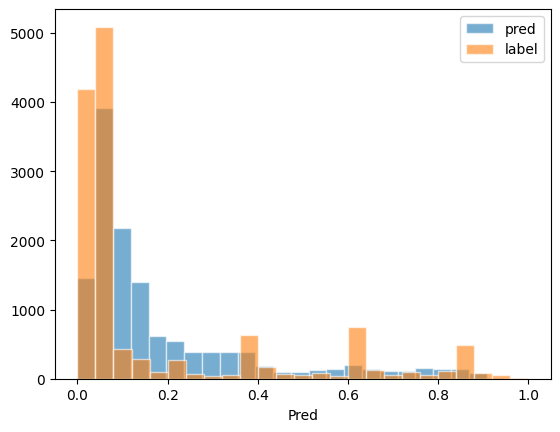

In [34]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [35]:
pred_df = test.copy()
pred_df["pred"] = np.mean(preds, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_TSAVI,knn_NormG,knn_IF,knn_sunAzimuth,knn_TIRS1,knn_Green,knn_TIRS2,knn_CTVI,knn_CI,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499,0.081727
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-0.463083,0.592326,3.004079,128.573050,8.792016,35.449848,8.814009,0.324673,-2.681994,0.133642
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-0.303412,0.441041,3.320265,127.929376,8.868892,46.699800,8.837255,0.581877,-0.717734,0.287014
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078907
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151522
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090430
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499,0.360554
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137109


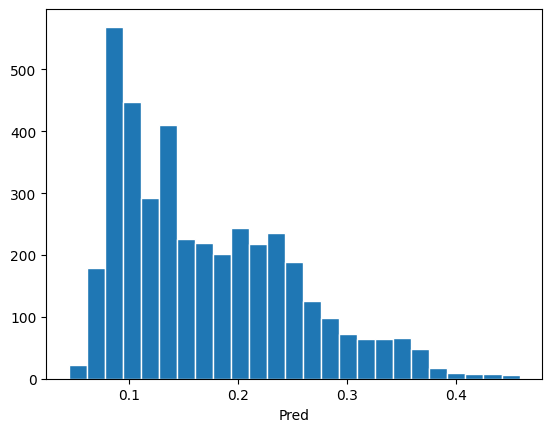

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_TSAVI,knn_NormG,knn_IF,knn_sunAzimuth,knn_TIRS1,knn_Green,knn_TIRS2,knn_CTVI,knn_CI,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499,0.081727
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,-0.463083,0.592326,3.004079,128.573050,8.792016,35.449848,8.814009,0.324673,-2.681994,0.133642
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,-0.303412,0.441041,3.320265,127.929376,8.868892,46.699800,8.837255,0.581877,-0.717734,0.287014
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078907
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151522
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090430
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,-0.346838,0.448051,3.429616,127.929376,8.857862,46.825167,8.838449,0.580183,-0.715499,0.360554
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137109


In [36]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_SEEDAVERAGE_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)